In [1]:

import jax
jax.config.update('jax_platforms', 'cpu')
import bmi
from src.libs.minde import MINDE
from scripts.helper import get_data_loader, get_default_config
from argparse import Namespace


/home/bounoua/work/minde/myvenv/lib/python3.9/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


In [2]:
bmi.benchmark.BENCHMARK_TASKS

{'1v1-normal-0.75': <bmi.benchmark.task.Task at 0x7fd1c5161220>,
 'normal_cdf-1v1-normal-0.75': <bmi.benchmark.task.Task at 0x7fd1c51614c0>,
 '1v1-additive-0.1': <bmi.benchmark.task.Task at 0x7fd1c5161a90>,
 '1v1-additive-0.75': <bmi.benchmark.task.Task at 0x7fd1c4870e50>,
 '1v1-bimodal-0.75': <bmi.benchmark.task.Task at 0x7fd1c480c340>,
 'wiggly-1v1-normal-0.75': <bmi.benchmark.task.Task at 0x7fd1c488a8e0>,
 'half_cube-1v1-normal-0.75': <bmi.benchmark.task.Task at 0x7fd1c480c910>,
 'student-identity-1-1-1': <bmi.benchmark.task.Task at 0x7fd1c5161820>,
 'asinh-student-identity-1-1-1': <bmi.benchmark.task.Task at 0x7fd1c480cd00>,
 'swissroll_x-normal_cdf-1v1-normal-0.75': <bmi.benchmark.task.Task at 0x7fd1c480f130>,
 'multinormal-dense-2-2-0.5': <bmi.benchmark.task.Task at 0x7fd1c480f520>,
 'multinormal-dense-3-3-0.5': <bmi.benchmark.task.Task at 0x7fd1c480fa30>,
 'multinormal-dense-5-5-0.5': <bmi.benchmark.task.Task at 0x7fd1c480faf0>,
 'multinormal-dense-25-25-0.5': <bmi.benchmark.tas

In [3]:
bmi.benchmark.BENCHMARK_TASKS
name_task = "1v1-normal-0.75"
name_task="multinormal-dense-2-2-0.5"
task = bmi.benchmark.BENCHMARK_TASKS[name_task]
task.mutual_information

0.2938933324510593

In [4]:
args = get_default_config()
args.type ="c"
args.test_epoch=1
args.use_ema = False
args.max_epochs=20
args.bs =512
args.lr = 1e-3
args.arch = "mlp"
args.importance_sampling = True
args.use_ema = True




In [5]:
train_l,test_l = get_data_loader(args,task)
model = MINDE(args,var_list={"x":task.dim_x,"y":task.dim_y}, gt = task.mutual_information)
#model.fit(train_l,test_l)



In [6]:
import numpy 
import matplotlib.pyplot as plt

def uniform_to_segment(x: numpy.array, min_length: float) -> numpy.array:
    """
    Map a 2D uniformly distributed random vector to a random segment.
    The coordinates of the ends are distributed uniformly, preserving order.
    
    Parameters
    ----------
    x : numpy.array
        Samples from an uniform distribution on [0; 1]^2, shape: (?,2).
    min_length : float, optional
        Minimum length of the segment (must be in [0; 1)).

    Returns
    -------
    coords : numpy.array
        Coordinates of the ends of sampled random segments.
    """
        
    if len(x.shape) != 2 or x.shape[1] != 2:
        raise TypeError("Parameter `x` must have shape (?,2)")
        
    if not (0.0 <= min_length < 1.0):
        raise ValueError("Parameter `min_length` must be in [0.0, 1.0)")

    coords = numpy.empty_like(x)

    # The first number is the left end.
    # It is linearly distributed from `0.0` to `1.0 - min_length`.
    coords[:,0] = (1.0 - min_length) * (1.0 - numpy.sqrt(1.0 - x[:,0]))

    # The last number is the right end.
    # Given the left end (condition), it is uniformly distributed
    # from the left end plus `min_length` to 1.0.
    coords[:,1] = x[:,1] * (1.0 - coords[:,0] - min_length) + coords[:,0] + min_length

    return coords


def uniform_to_rectangle(x: numpy.array, min_width: float=0.0, min_height: float=0.0,
                         max_width: float=1.0, max_height: float=1.0) -> numpy.array:
    """
    Map a 4D uniformly distributed random vector to a random rectangle.
    The coordinates of the corners are distributed uniformly, preserving order.
    
    Parameters
    ----------
    x : numpy.array
        Samples from an uniform distribution on [0; 1]^4, shape: (?,4).
    min_width : float, optional
        Minimum width of the rectangle.
    min_height : float, optional
        Minimum height of the rectangle.
    max_width : float, optional
        Maximum width of the rectangle.
    max_height : float, optional
        Maximum height of the rectangle.

    Returns
    -------
    coords : numpy.array
        Coordinates of the corners of sampled random rectangles.
    """

    if len(x.shape) != 2 or x.shape[1] != 4:
        raise TypeError("Parameter `x` must have shape (?,2)")

    coords = numpy.empty_like(x)
    coords[:,0:2] = uniform_to_segment(x[:,0:2], min_width  / max_width)  * max_width
    coords[:,2:4] = uniform_to_segment(x[:,2:4], min_height / max_height) * max_height

    return coords


def draw_rectangle(coords: numpy.array, image_width: int, image_height: int) -> numpy.array:
    """
    Map coordinates of rectangles to rasterized images of rectangles.
    
    Parameters
    ----------
    coords : numpy.array
        Normalized coordinates of the corners of rectangles, shape: (?,4).
    image_width : int
        Image width in pixels.
    image_height : int
        Image height in pixels.
    """

    if len(coords.shape) != 2 or coords.shape[1] != 4:
        raise TypeError("Parameter `coords` must have shape (?,4)")
        
    n_samples = coords.shape[0]

    # Denormalized coordinates.
    denormalized_coords = numpy.empty_like(coords)
    denormalized_coords[:,0:2] = coords[:,0:2] * image_width
    denormalized_coords[:,2:4] = coords[:,2:4] * image_height

    #integer_denormalized_coords = denormalized_coords.astype(int)

    # Grid.
    grid_x = numpy.arange(image_width)
    grid_y = numpy.arange(image_height)

    # Images generation.
    images_x = numpy.clip(numpy.minimum(grid_x[None,...] - denormalized_coords[:,0,None], denormalized_coords[:,1,None] - grid_x[None,...]), 0.0, 1.0)
    images_y = numpy.clip(numpy.minimum(grid_y[None,...] - denormalized_coords[:,2,None], denormalized_coords[:,3,None] - grid_y[None,...]), 0.0, 1.0)
    images = images_x[:,:,None] * images_y[:,None,:]

    return images

    # Run uniform_to_rectangle function
    

N = 10

random_array = numpy.random.uniform(size=(N, 4))

def to_images(random_array,res):
    rectangle_coords = uniform_to_rectangle(random_array)
    # Run draw_rectangle function
  
    images = draw_rectangle(rectangle_coords, res, res)
    return images

def plot_images(images):
    
    fig, axes = plt.subplots(1, len(images), figsize=(len(images), 1))
    for i in range( len(images)):
        
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

In [7]:
import numpy as np 
def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

def sample_correlated_gaussian(mi=0.5, dim=4, batch_size=128, to_cuda=False, cubic = False):
    """Generate samples from a correlated Gaussian distribution."""
    rho = mi_to_rho(mi, dim)
    
    mean = [0,0]
    cov = [[1.0, rho],[rho, 1.0]]
    x, y = np.random.multivariate_normal(mean, cov, batch_size * dim).T

    x = x.reshape(-1, dim)
    y = y.reshape(-1, dim)

    if cubic:
        y = y ** 3

    if to_cuda:
        x = torch.from_numpy(x).float().cuda()
        #x = torch.cat([x, torch.randn_like(x).cuda() * 0.3], dim=-1)
        y = torch.from_numpy(y).float().cuda()
    return x, y

In [8]:
import numpy as np
from scipy.stats import norm
from sklearn.feature_selection import mutual_info_regression

def generate_correlated_uniforms(dimension, n_samples, correlation):
    # Step 1: Generate independent Gaussian variables
    mean = np.zeros(2 * dimension)
    cov = (1 - correlation) * np.eye(2 * dimension) + correlation * np.ones((2 * dimension, 2 * dimension))
    
    # Generate correlated Gaussian samples
    Z = np.random.multivariate_normal(mean, cov, n_samples)
    
    # Step 2: Convert Gaussian samples to uniform samples using the CDF
    U = norm.cdf(Z)

    # U is now uniformly distributed between 0 and 1 with the specified correlation
    return U[:, :dimension], U[:, dimension:]  

def compute_mutual_information(X, Y):
    # Flatten the arrays for mutual information calculation
    X_flat = X.flatten().reshape(-1, 1)
    Y_flat = Y.flatten()

    # Estimate mutual information
    mi = mutual_info_regression(X_flat, Y_flat, discrete_features=False)
    return mi.mean()

# Set parameters
dimension = 4
n_samples = 10000
correlation = 0.7  # Adjust correlation factor

# Generate correlated uniform variables
X_corr, Y_corr = generate_correlated_uniforms(dimension, n_samples, correlation)

# Compute mutual information
mi = compute_mutual_information(X_corr, Y_corr)

print(f"Estimated Mutual Information: {mi:.4f}")

# Verify if the variables are uniform
print(f"Range of X: [{X_corr.min():.4f}, {X_corr.max():.4f}]")
print(f"Range of Y: [{Y_corr.min():.4f}, {Y_corr.max():.4f}]")

Estimated Mutual Information: 0.3412
Range of X: [0.0001, 1.0000]
Range of Y: [0.0000, 1.0000]


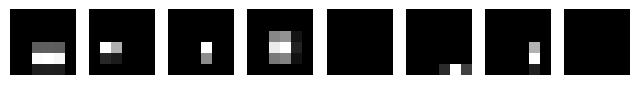

In [9]:
x = to_images(X_corr,6)
plot_images(x[:8])

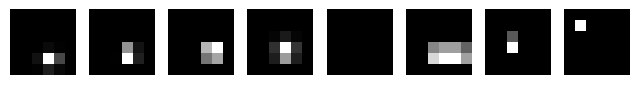

In [10]:
y = to_images(Y_corr,6)
plot_images(y[:8])

In [11]:
from torch.utils.data import Dataset ,DataLoader
import torch
from sklearn import preprocessing
from scripts.config import get_config
import numpy as np
from scripts.helper import SynthetitcDataset

def get_data_loader_images(args,res ):

    size_train = args.Train_Size
    size_test = args.Test_Size
    
    X, Y = generate_correlated_uniforms(4, 100000+10000, 0.8)
    mi = compute_mutual_information(X[:10000], Y[:10000])
    
    X = to_images(X,res).reshape(X.shape[0],res**2)
    Y = to_images(Y,res).reshape(Y.shape[0],res**2)
    #X, Y = task.sample(size_test+size_train, seed=args.seed)
    
    
    # if args.preprocessing == "rescale":
    #     X = preprocessing.StandardScaler(copy=True).fit_transform(X)
    #     Y = preprocessing.StandardScaler(copy=True).fit_transform(Y)
    
    
    x_train , y_train =  X[:size_train,], Y[:size_train,]
    x_test , y_test =  X[size_train:,], Y[size_train:,]
    

    data_train, data_test =  [x_train , y_train], [x_test , y_test]


    train, test = SynthetitcDataset(data_train),SynthetitcDataset(data_test)


    train_loader = DataLoader(train, batch_size=256,
                          shuffle=True,
                          num_workers=8, drop_last=True,pin_memory =True)

    test_loader = DataLoader(test, batch_size=1000,
                          shuffle= False,
                          num_workers=8, drop_last=False,pin_memory =True)
    

    return train_loader,test_loader,mi

In [12]:
args = get_default_config()
args.type ="c"
args.test_epoch=1
args.use_ema = False
args.max_epochs=100
args.bs =512
args.lr = 1e-3
args.arch = "tx_img"
args.importance_sampling = True
args.use_ema = True

res = 16
train, test, mi = get_data_loader_images(args,res)
model = MINDE(args,var_list={"x":res*res,"y":res*res}, gt = mi)
model.fit(train,test)


/home/bounoua/miniconda3/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bounoua/miniconda3/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch:  1  GT:  0.511 MINDE_estimate:  1.529 MINDE_sigma_estimate:  7.566
Epoch:  2  GT:  0.511 MINDE_estimate:  1.376 MINDE_sigma_estimate:  13.601
Epoch:  3  GT:  0.511 MINDE_estimate:  1.212 MINDE_sigma_estimate:  15.723
Epoch:  4  GT:  0.511 MINDE_estimate:  1.535 MINDE_sigma_estimate:  13.124
Epoch:  5  GT:  0.511 MINDE_estimate:  1.363 MINDE_sigma_estimate:  27.771
Epoch:  6  GT:  0.511 MINDE_estimate:  1.521 MINDE_sigma_estimate:  -23.059
Epoch:  7  GT:  0.511 MINDE_estimate:  1.229 MINDE_sigma_estimate:  12.995
Epoch:  8  GT:  0.511 MINDE_estimate:  1.313 MINDE_sigma_estimate:  9.948
Epoch:  9  GT:  0.511 MINDE_estimate:  1.549 MINDE_sigma_estimate:  26.135
Epoch:  10  GT:  0.511 MINDE_estimate:  1.553 MINDE_sigma_estimate:  19.267
Epoch:  11  GT:  0.511 MINDE_estimate:  1.73 MINDE_sigma_estimate:  -13.885


Exception ignored in: <function _releaseLock at 0x7fd1ed095a60>
Traceback (most recent call last):
  File "/home/bounoua/miniconda3/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch:  12  GT:  0.511 MINDE_estimate:  1.238 MINDE_sigma_estimate:  -11.576
